#Imports

In [55]:
# Imports
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import pandas as pd
import os
import PIL
import torch
import time
import progressbar
import shutil
import geopandas as gpd
import random
from math import sqrt, ceil, floor
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary
from torch.optim import Adam

# Get our Resnet model
from torchvision.models import ResNet152_Weights

from google.colab import drive
drive.mount('/content/drive')

# Local directories
DATA_ROOT_DIR = pathlib.Path('/content/kaggle/')
TENSOR_DATA_DIR = pathlib.Path('/content/kaggle/tensor_data')
DATA_DIR_25K = pathlib.Path('/content/kaggle/street_view_25k')
DATA_DIR_50K = pathlib.Path('/content/kaggle/50k_geoguessr_BALANCED')
DATA_DIR_API = pathlib.Path('/content/kaggle/google_api')

MODEL_RESNET_PATH = "/content/drive/MyDrive/Kaggle/resnet_model.pt"

# Training parameters
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.003

# Data constants
ORIGINAL_DIM = 640
TARGET_SCALE = .1
TARGET_DIM = 224

# Progress bar widget
widgets = [
    ' [',
    progressbar.Timer(format= 'elapsed time: %(elapsed)s'),
    '] ',
    progressbar.Bar('*'),' (',
    progressbar.ETA(), ') ',
]

# Specifying training device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cpu


# Data

In [ ]:
# Load Tensor Dataset
! mkdir /content/kaggle/
! unzip /content/drive/MyDrive/Kaggle/tensor_set_4.zip -d $TENSOR_DATA_DIR

In [ ]:
# Download and unzip the image datasets into our local machine
! unzip /content/drive/MyDrive/Kaggle/street_view_25k.zip -d $DATA_ROOT_DIR
! unzip /content/drive/MyDrive/Kaggle/google_api.zip -d $DATA_ROOT_DIR
! unzip /content/drive/MyDrive/Kaggle/50k_geoguessr_BALANCED -d $DATA_ROOT_DIR

##Analysis & Visualization

Total size of dataset: 94152
{'United States': 3542, 'Canada': 3505, 'Mexico': 2701, 'Brazil': 2645, 'Australia': 2360, 'Poland': 2195, 'Spain': 2170, 'South Africa': 2069, 'Thailand': 1957, 'Russia': 1905, 'Finland': 1853, 'Argentina': 1840, 'Sweden': 1838, 'Italy': 1736, 'France': 1681, 'United Kingdom': 1584, 'Japan': 1493, 'Norway': 1393, 'Indonesia': 1356, 'Nigeria': 996, 'Malaysia': 974, 'Portugal': 966, 'Romania': 951, 'New Zealand': 919, 'Netherlands': 891, 'Germany': 880, 'Colombia': 824, 'Turkey': 821, 'Chile': 791, 'Singapore': 766, 'Ireland': 761, 'Austria': 735, 'Philippines': 713, 'Czechia': 692, 'Peru': 683, 'India': 603, 'South Korea': 585, 'Bulgaria': 569, 'Israel': 558, 'Taiwan': 555, 'Kenya': 538, 'Greece': 524, 'Ukraine': 501, 'Belgium': 493, 'Lithuania': 458, 'Denmark': 450, 'Switzerland': 446, 'Botswana': 427, 'Hungary': 407, 'Mongolia': 392, 'Sri Lanka': 391, 'Slovakia': 326, 'Cambodia': 325, 'Croatia': 319, 'Latvia': 317, 'Senegal': 298, 'Uruguay': 285, 'Ghana':

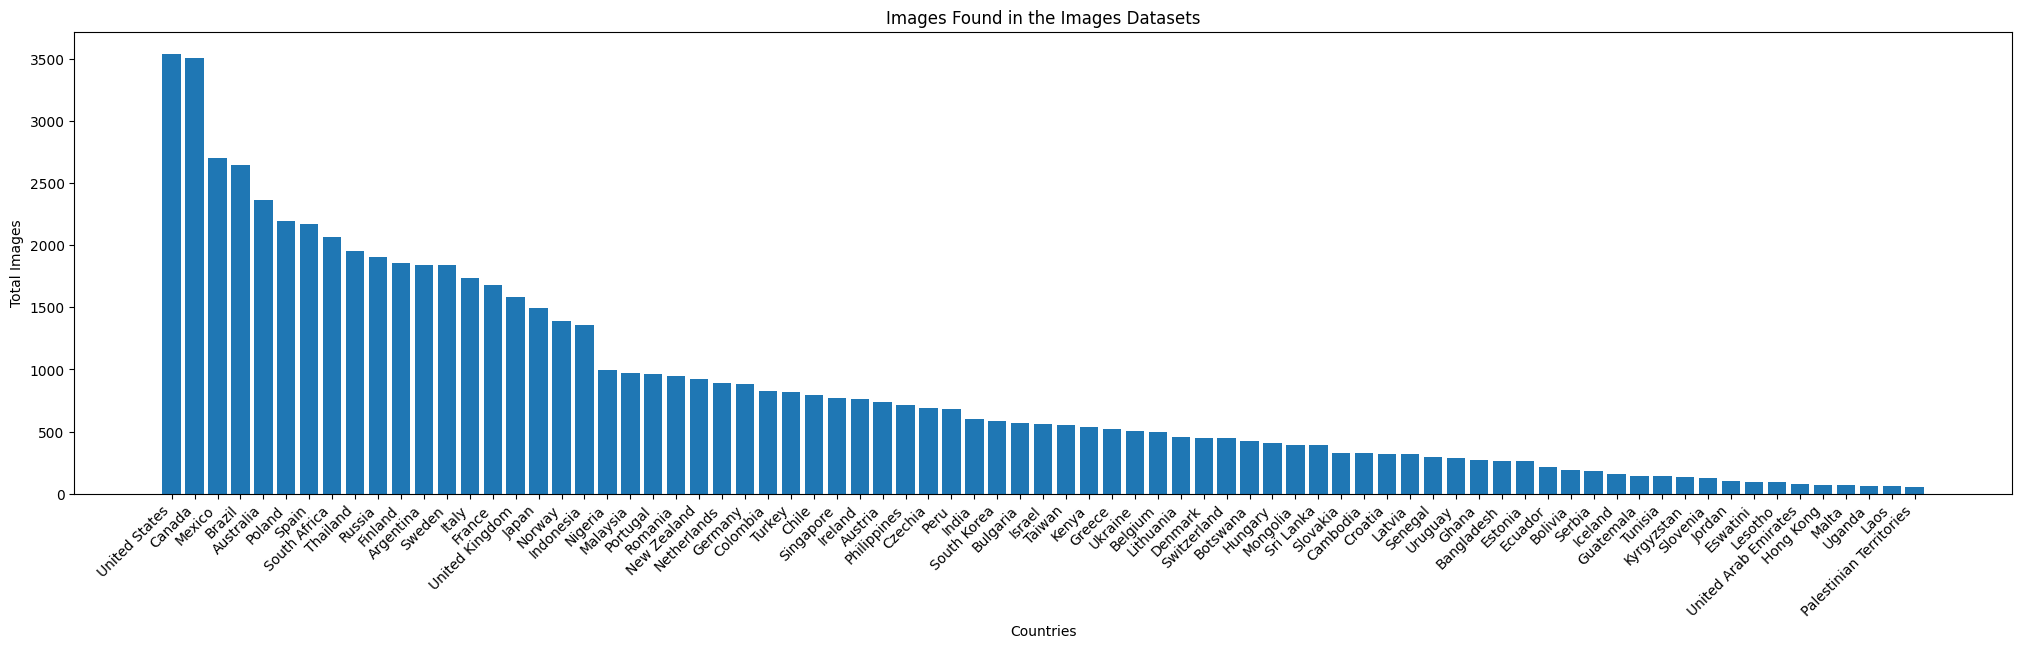

Total size of dataset: 94152
{'United States': 4542, 'Canada': 4505, 'Brazil': 3645, 'Mexico': 3602, 'Australia': 3360, 'Spain': 3170, 'South Africa': 3069, 'Poland': 3058, 'Russia': 2905, 'Thailand': 2901, 'Finland': 2853, 'France': 2681, 'United Kingdom': 2584, 'Sweden': 2564, 'Argentina': 2529, 'Italy': 2525, 'Japan': 2493, 'Norway': 2068, 'Indonesia': 1644, 'Germany': 1578, 'New Zealand': 1476, 'Singapore': 1473, 'Netherlands': 1470, 'Malaysia': 1397, 'Romania': 1297, 'Portugal': 1208, 'Nigeria': 1119, 'Chile': 1117, 'Taiwan': 1102, 'Turkey': 1089, 'Austria': 1082, 'Colombia': 1075, 'Ireland': 1051, 'Peru': 953, 'Czechia': 949, 'Philippines': 932, 'Israel': 884, 'South Korea': 828, 'Bulgaria': 786, 'Greece': 772, 'India': 763, 'Belgium': 712, 'Kenya': 668, 'Denmark': 648, 'Switzerland': 619, 'Ukraine': 615, 'Lithuania': 598, 'Hungary': 575, 'Botswana': 571, 'Sri Lanka': 476, 'Mongolia': 475, 'Croatia': 448, 'Cambodia': 443, 'Latvia': 434, 'Slovakia': 434, 'Ghana': 381, 'Senegal': 3

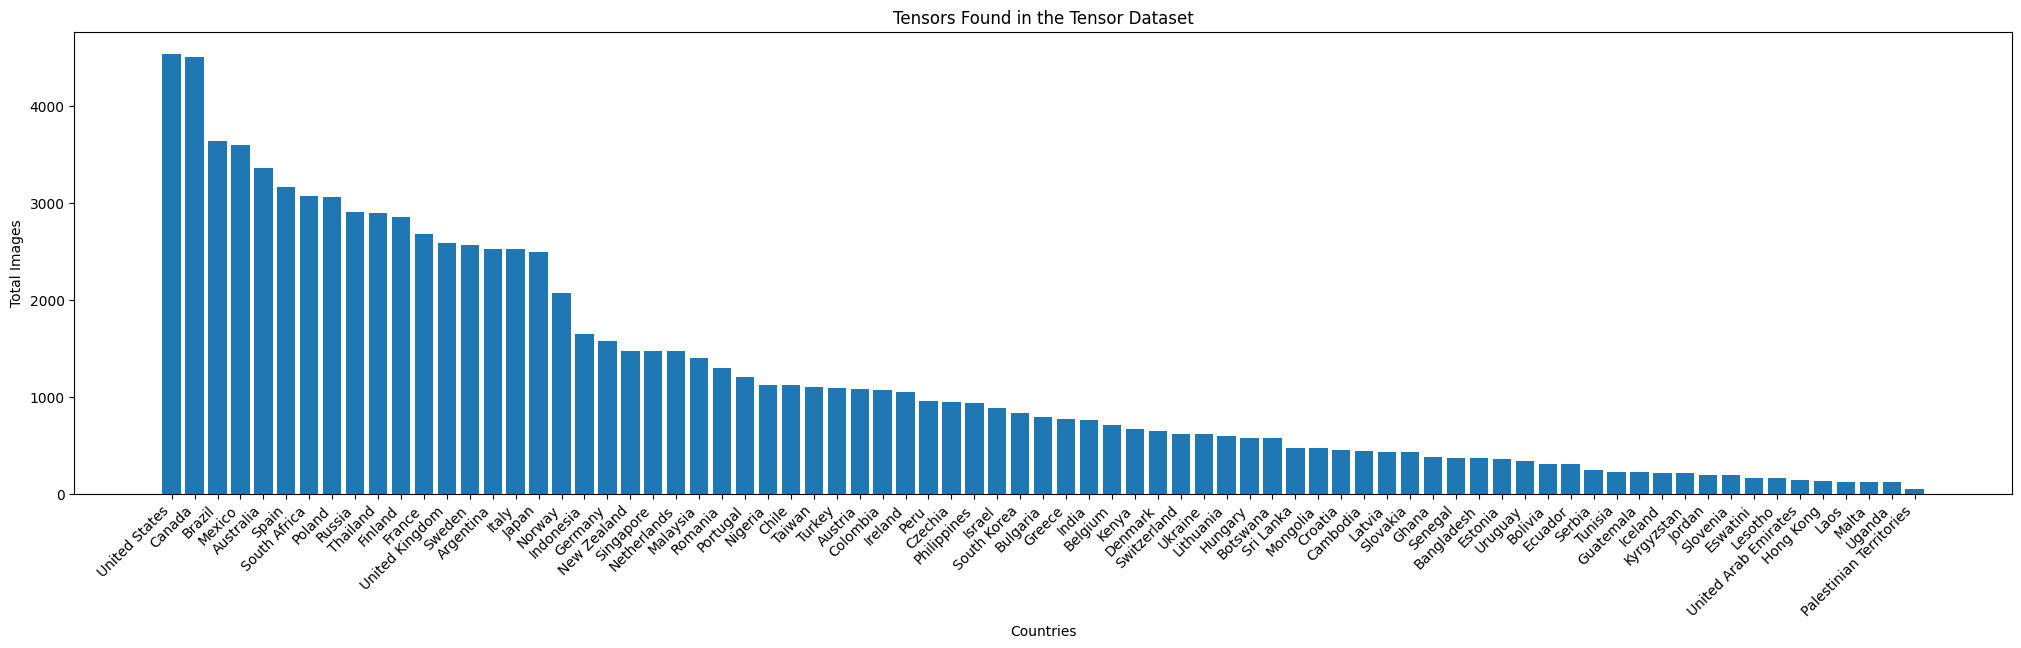

In [56]:
# Data distribution: how many images do we have per country in our datasets?

def count_samples(path):
    """ Return Country and Total # of Items per Country in this folder """
    return path.name, len(list(path.glob('*')))

def distributions(datasets):
    """
      Returns a dictionary with key-value pairs being:
        {'Country': [dataset1_count, dataset2_count, ...], 'Country2': ...}
    """
    counts = {}
    total_images = 0
    for dataset in datasets:
        for country, total in dataset.items():
            if country not in counts:
                counts[country] = [0] * len(datasets)
            counts[country][datasets.index(dataset)] = total
            total_images += total
    return total_images, counts

def plot_graph(data_distr, title):
    """ Bar Graph to visualize Data Distribution """
    countries = list(data_distr.keys())
    n_imgs = list(data_distr.values())

    plt.figure(figsize=(25, 6))
    plt.bar(countries, n_imgs)
    plt.xlabel('Countries')
    plt.ylabel('Total Images')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.show()


def dataset_to_bar_graph(title, data_directories, min_countries=None, max_countries=None):
    """
      Plots a bar graph given a list of data_directories.
      Serves as adata analysis tool to examine all countries -> total images

      The parameters min_countries and filter_max determine the min and max number of
      images per country in the visualization
    """
    datasets = []

    # Make dictionary for each dataset -> mapping country to its number of images
    for dir in data_directories:
        datasets.append(dict(sorted(map(count_samples, dir.glob('*/')))))

    # Combine the datasets into one data structure with all data -> data analysis
    total_imgs, counts = distributions(datasets)
    print(f"Total size of dataset: {total_imgs}")

    # Combine all data into a simple dictionary -> mapping country to # of images
    total_counts = {country: sum(data) for country, data in counts.items()}
    sorted_counts = dict(sorted(total_counts.items(), key=lambda item: item[1], reverse=True))

    # Filtering step -> data balancing tests
    if min_countries:
        sorted_counts = {c: d for c, d in sorted_counts.items() if d >= min_countries}
    elif max_countries:
        sorted_counts = {c: max_countries if d > max_countries else d for c, d in sorted_counts.items()}

    print(sorted_counts)
    plot_graph(sorted_counts, title)

img_datasets = [DATA_DIR_50K, DATA_DIR_50K, DATA_DIR_25K, DATA_DIR_API]
dataset_to_bar_graph("Images Found in the Images Datasets", img_datasets, 50)
dataset_to_bar_graph("Tensors Found in the Tensor Dataset", [TENSOR_DATA_DIR], 50)

<ipython-input-44-f40ed5344a72>:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


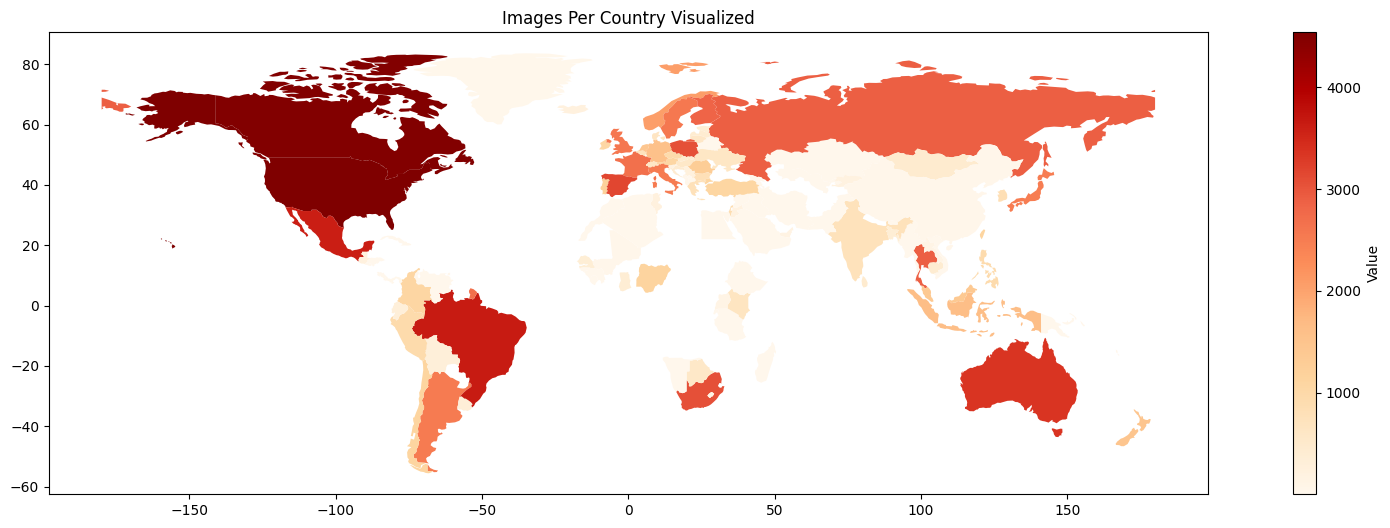

In [ ]:
# Geographical Visualization: what do our distributions look like?

def plot_world(data_directory, title):
    """ Plots a geographical heat map for the total # of images per country """

    data_distr = dict(sorted(map(count_samples, data_directory.glob('*/'))))

    # Edge case for different country names
    data_distr['United States of America'] = data_distr['United States']

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    gpd_countries = set(world['name'].unique()) # Unique (gpd) country names
    data_countries = set(data_distr.keys())

    # Merge the world map with the data from our dictionary
    world_subset = world[world['name'].isin(data_distr.keys())]
    world_subset = world_subset.merge(
        pd.DataFrame(list(data_distr.items()), columns=['Country', 'Value']),
        how='left',
        left_on='name',
        right_on='Country'
    )

    # Plot our world map distribution
    fig, ax = plt.subplots(1, 1, figsize=(22, 6))
    world_subset.plot(column='Value', ax=ax, legend=True, cmap='OrRd',
                      legend_kwds={'label': "Value"},
                      missing_kwds={'color': 'lightgrey'})
    plt.title(title)
    plt.show()

plot_world(TENSOR_DATA_DIR, 'Images Per Country Visualized')


##Pre-Process Data

In [ ]:
# Pre Process Data - Original dataset for combining images

def l_crop(image):
    return transforms.functional.crop(image, 0, 65, ORIGINAL_DIM, ORIGINAL_DIM)

def r_crop(image):
    return transforms.functional.crop(image, 0, 614, ORIGINAL_DIM, ORIGINAL_DIM)

def transform(t_type):

    if t_type == "base":
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((TARGET_DIM, TARGET_DIM)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    elif t_type == "left":
        crop = transforms.Lambda(l_crop)

    else:
        crop = transforms.Lambda(r_crop)

    return transforms.Compose([
        transforms.ToTensor(),
        crop,
        transforms.Resize((TARGET_DIM, TARGET_DIM)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


class MergedDataset(Dataset):
    """Class to Merge Image Folder Datasets

    Need to have consistent class to index mapping even when there are
    multiple datasets. This class will merge multiple datasets together
    and provide a consistent mapping from class to index.

    TODO: filter out countries without enough data
    """

    def __init__(self, datasets):
        """Initialize MergedDataset

        Args:
            datasets (list): List of ImageFolder datasets to merge
        """
        self.datasets = datasets
        self.class_to_idx = {}
        self.classes = []
        self.x = []
        self.y = []
        self.transforms = []
        self._merge_mappings()

    def _merge_mappings(self):
        """Merge class_to_idx mappings from each dataset

        This will merge the class_to_idx mappings from each dataset
        and create a consistent mapping from class to index.
        """
        idx = 0
        for dataset in self.datasets:
            for key in dataset.class_to_idx.keys():
                if key not in self.class_to_idx:
                    self.class_to_idx[key] = idx
                    self.classes.append(key)
                    idx += 1

        # Merge the dataset data and labels
        for dataset in self.datasets:
            for img, label in dataset.imgs:
                self.x.append(img)
                self.y.append(self.class_to_idx[dataset.classes[label]])
                self.transforms.append(dataset.transform)

    def __getitem__(self, ix):

        # Load image using path
        path = self.x[ix]
        transform = self.transforms[ix]
        x = None
        with open(path, "rb") as f:
            img = Image.open(f)
            img = img.convert("RGB")
            x = transform(img).to(device)
        y = torch.tensor(self.y[ix]).to(device)
        return x, y

    def __len__(self):
        return len(self.x)

# Remove a hidden directory that was causing errors
!rmdir /content/kaggle/google_api/.ipynb_checkpoints

# Create Image Folders then Merge
dataset_l = torchvision.datasets.ImageFolder(root=DATA_DIR_50K, transform=transform("left"))
dataset_r = torchvision.datasets.ImageFolder(root=DATA_DIR_50K, transform=transform("right"))
dataset_25k = torchvision.datasets.ImageFolder(root=DATA_DIR_25K, transform=transform("base"))
dataset_api = torchvision.datasets.ImageFolder(root=DATA_DIR_API, transform=transform("base"))
dataset = MergedDataset([dataset_l, dataset_r, dataset_25k, dataset_api])
num_countries = len(dataset.class_to_idx)
print(f"Length of dataset: {len(dataset)}")
print(f"Number of Countries: {len(dataset.class_to_idx)}")
print(dataset.class_to_idx)

# Plot sample split image
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(dataset_l[0][0].cpu().permute(1, 2, 0))
axes[1].imshow(dataset_r[0][0].cpu().permute(1, 2, 0))

# Split the dataset -> 80% of data for training and 20% for testing
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

# Create DataLoader instances for training and testing
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(len(dataset))

In [ ]:
# Create custom dataset with tensors instead of images

# ! pip install pycountry_convert
import pycountry_convert as pc

def continent_from_country(country):
    country_code = pc.country_name_to_country_alpha2(country)
    return pc.country_alpha2_to_continent_code(country_code)

class TensorDataset(Dataset):
    """
    The TensorDataset class is designed for tensors with associated labels,
    primarily focused on geographical data.
    It provides filtering and data distribution functionalities.

    Attributes:
    - `dataset`: The underlying DatasetFolder containing raw tensors.
    - `samples`: A list of tuples representing (tensor_path, label) for valid countries.
    - `class_to_idx`: A mapping from country to label.
    - `classes`: A set of valid countries.
    - `n_countries`: The number of valid countries.
    - `idx_to_class`: A mapping from label to country.
    - `label_distr`: A mapping from label to the range of samples associated with that label.
    - `is_uniform`: A boolean for whether or not we will retrieve items uniformly.
    """

    def __init__(self, dataset, is_uniform=False, continent_ds=False, min_tensors=50):
        self.dataset = dataset
        self.samples = []
        self.class_to_idx = {}
        self.classes = set()
        self.n_countries = 0
        self.idx_to_class = {}
        self.label_distr = {}
        self.is_uniform = is_uniform

        # Initializes and filters the dataset based on f_min and f_max
        self.filter_countries(min_tensors)

        if continent_ds:
            # Changes into a continents (rather than countries) dataset
            self.to_continents()

    def filter_countries(self, min_tensors):
        """ Filter and process the dataset, keeping only samples from valid
        countries. """
        root = self.dataset.root

        # A country is valid only if it contains >= min_tensors
        valid_countries = set()
        for country in self.dataset.classes:
            country_path = os.path.join(root, country)
            n_tensors = len([t for t in os.listdir(country_path) if t.endswith('pt')])
            if n_tensors >= min_tensors:
                valid_countries.add(country)

        self.classes = valid_countries
        self.n_countries = len(valid_countries)
        self.class_to_idx = {country: i for i, country in enumerate(valid_countries)}
        self.idx_to_class = {i: country for country, i in self.class_to_idx.items()}

        original_idx_to_class = {i: country for country, i in self.dataset.class_to_idx.items()}

        i = 0
        for tensor, label in self.dataset.samples:
            # A sample is added only if it is from the list of valid countries
            if original_idx_to_class[label] in self.classes:
                new_label = self.class_to_idx[original_idx_to_class[label]]
                self.samples.append((os.path.join(root, self.idx_to_class[new_label], tensor), new_label))

                # Uniform/Not-uniform Distribution Logic for get_item
                if new_label not in self.label_distr:
                    self.label_distr[new_label] = [i, i]
                else:
                    self.label_distr[new_label][1] = i

                i += 1

    def to_continents(self):
        """ Transform the dataset to represent continents instead of individual
        countries. """
        i = 0
        continents = set()
        self.class_to_idx = {}
        new_samples = []
        self.label_distr = {}
        for path, label in self.samples:
            try:
                continent = continent_from_country(self.idx_to_class[label])
                if continent not in continents:
                    continents.add(continent)
                    self.class_to_idx[continent] = len(self.class_to_idx)
                new_samples.append((path, self.class_to_idx[continent]))
            except Exception as e:
                print(f"Couldn't get location for {label}: {e}")

            if continent not in self.label_distr:
                self.label_distr[continent] = [i, i]
            else:
                self.label_distr[continent][1] = i
            i += 1

        self.idx_to_class = {i: country for country, i in self.class_to_idx.items()}
        self.samples = new_samples

    def __getitem__(self, i):

        """
        Retrieve a specific sample from the dataset.
        There are two cases here:
            First case: we sample from all of the data (not uniformly)
            Second case: we sample the countries uniformly
        """
        idx = i

        if self.is_uniform and random.random() < 0.5:
            # With a coin flip, we can switch to a uniform distribution
            country = i % self.n_countries
            start, end = self.label_distr[country]
            idx = random.randint(start, end)

        tensor_path, label = self.samples[idx]
        tensor = torch.load(tensor_path)

        return tensor, label


    def __len__(self):
        return len(self.samples)

In [ ]:
# Construct dataset and loaders
tensor_dataset = torchvision.datasets.DatasetFolder(root=TENSOR_DATA_DIR, loader=torch.load, extensions=(".pt"))
tensor_dataset = TensorDataset(tensor_dataset)

# Split the dataset randomly -> 80% of data for training and 20% for testing
train_ratio = 0.8
train_size = int(train_ratio * len(tensor_dataset))
test_size = len(tensor_dataset) - train_size
train_data, test_data = random_split(tensor_dataset, [train_size, test_size])


num_countries = tensor_dataset.n_countries

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
print(f"Total size of our dataset: {len(tensor_dataset)}")
print(f"Total number of countries: {num_countries}")

Total size of our dataset: 93750
Total number of countries: 77


#Models

##Architectures

In [59]:
class SimpleGuesser(nn.Module):
    """
    A simple classifier model to run tests on
    """
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 8, 3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 1, 3),
            nn.ReLU(),
            nn.BatchNorm2d(1),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(2916, num_countries)
        ).to(device)

    def forward(self, x):
        return self.layers(x)


model = SimpleGuesser().to(device)
summary(model, (3, TARGET_DIM, TARGET_DIM))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             224
              ReLU-2          [-1, 8, 222, 222]               0
       BatchNorm2d-3          [-1, 8, 222, 222]              16
         MaxPool2d-4          [-1, 8, 111, 111]               0
            Conv2d-5          [-1, 1, 109, 109]              73
              ReLU-6          [-1, 1, 109, 109]               0
       BatchNorm2d-7          [-1, 1, 109, 109]               2
         MaxPool2d-8            [-1, 1, 54, 54]               0
           Flatten-9                 [-1, 2916]               0
           Linear-10                   [-1, 77]         224,609
Total params: 224,924
Trainable params: 224,924
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 10.09
Params size (MB): 0.86
Estimated 

In [62]:
# Set up a Classifier model to use for transfer learning
classifier = nn.Sequential(
    nn.Linear(2048, 100),
    nn.ReLU(),
    nn.Linear(100, num_countries),
    nn.ReLU()
).to(device)

##Training

In [ ]:
# Train Model
def train_batch(model, X_train, Y_train, opt, loss):
    opt.zero_grad()                   # Flush memory
    pred = model(X_train)             # Get predictions
    batch_loss = loss(pred, Y_train)  # Compute loss
    batch_loss.backward()             # Backpropagation - compute gradients
    opt.step()                        # Make a GD step
    return batch_loss.detach().cpu().numpy()


def train(model, train_dl, epochs, optimizer, loss):

    model.train()
    loss_history = []
    start = time.time()
    for epoch in range(epochs):

        print(f"Running Epoch {epoch + 1} of {epochs}")
        print(f"TOTAL BATCHES: {len(train_dl)}")

        epoch_losses = []
        bar = progressbar.ProgressBar(max_value=len(train_dl), widgets=widgets).start()
        for i, batch in enumerate(train_dl):

            x, y = batch
            x, y = x.to(device), y.to(device)
            batch_loss = train_batch(model, x, y, optimizer, loss)
            epoch_losses.append(batch_loss)
            bar.update(i)

        epoch_loss = np.mean(epoch_losses)
        loss_history.append(epoch_loss)
        print(f"Epoch Loss: {epoch_loss}")

    end = time.time()
    training_time = end - start
    return loss_history, training_time

model = classifier
loss = nn.CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr=.001)

# Training the model
loss_history, train_time = train(model, train_loader, 10, optimizer, loss)
print(loss_history)
print(train_time)

# Save
torch.save(model.state_dict(), MODEL_RESNET_PATH)

##Testing

In [ ]:
# Load the saved model
classifier.load_state_dict(torch.load(MODEL_RESNET_PATH))

# Test Model
def accuracy(model, test_loader):

    print("Computing accuracy...")

    # Set the model to evaluation mode - disabling gradient calculation
    model.eval()

    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        bar = progressbar.ProgressBar(max_value=len(test_loader), widgets=widgets).start()
        for i, batch in enumerate(test_loader):
            # Forward pass
            inputs, labels = batch
            # print(inputs.size())
            inputs = inputs.to(device)
            outputs = model(inputs)

            # Get predictions
            _, predicted = torch.max(outputs, 1)

            # Update counts
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels.to(device)).sum().item()

            # For testing the predictions:
            # true_labels = [counts_50k[idx.item()] for idx in labels]
            # predicted_labels = [counts_50k[idx.item()] for idx in predicted]

            # for i in range(len(true_labels)):
            #   print(f"{true_labels[i]}: predicted {predicted_labels[i]}")
            # break

            bar.update(i)

    # Calculate accuracy
    print(f"Correct Predictions: {correct_predictions}, Total Samples {total_samples}")
    return correct_predictions / total_samples

accuracy_model = accuracy(model, test_loader)
print(f"Model Accuracy: {accuracy_model}")



```
# These are programs we needed at one point but not anymore
```

# Old Code Archive

In [ ]:
# Folder Reformatting into Country Sub-Structure - SUCCESFUL

# import os
# import pandas as pd
# from geopy.geocoders import Nominatim

# # Step 1: Set up data and coordinate df
# dataset1 = DATA_DIR
# dataset2 = "/content/kaggle/Streetview_Image_Dataset"
# coordinates_file = "/content/kaggle/Streetview_Image_Dataset/coordinates.csv"
# coordinates_df = pd.read_csv(coordinates_file)
# print(coordinates_df)
# print(coordinates_df.index)

# # Step 2: Reverse Geocoding
# geolocator = Nominatim(user_agent="geo_reverse")

# # Step 3: Merge Images
# for image_filename in os.listdir(dataset2):
#     image_number = int(os.path.splitext(image_filename)[0])
#     if image_number in coordinates_df.index:
#         latitude, longitude = coordinates_df.loc[image_number, ['latitude', 'longitude']]
#         location = geolocator.reverse((latitude, longitude), language='en')
#         country = location.raw['address']['country']
#         print(country)

#         # Move or copy the image to the corresponding country folder in dataset1
#         try:
#             source_path = os.path.join(dataset2, image_filename)
#             destination_path = os.path.join(dataset1, country, image_filename)

#             os.makedirs(os.path.dirname(destination_path), exist_ok=True)
#             shutil.move(source_path, destination_path)
#         except Exception as e:
#             print(f"Couldn't move to folder {country} - {e}")


In [ ]:
# We can save this in case we need it later but we don't need it anymore

# # Set up the dataset locally
# ! pip install kaggle

# # Get kaggle key and set up in .kaggle directory
# ! mkdir ~/.kaggle
# ! cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json

# # Download and unzip the data into data dir
# ! kaggle datasets download -d ubitquitin/geolocation-geoguessr-images-50k
# ! unzip /content/geolocation-geoguessr-images-50k.zip -d $DATA_ROOT_DIR
# ! rm /content/geolocation-geoguessr-images-50k.zip

In [ ]:
# # Checkout image dimensions from all datasets - SUCCESFUL
# from PIL import Image

# def get_image_dimensions(image_path):
#     with Image.open(image_path) as img:
#         width, height = img.size
#     return width, height

# image_path = "/content/kaggle/street_view_25k/Albania/1119.jpg"
# width, height = get_image_dimensions(image_path)
# print(f"Image dimensions Dataset 25k: {width} x {height}")
# image_path = "/content/kaggle/50k_geoguessr_BALANCED/Argentina/canvas_1629257860.jpg"
# width, height = get_image_dimensions(image_path)
# print(f"Image dimensions Dataset 50k: {width} x {height}")
# image_path = "/content/kaggle/google_api/Albania/0.jpg"
# width, height = get_image_dimensions(image_path)
# print(f"Image dimensions Dataset API: {width} x {height}")

Image dimensions Dataset 25k: 640 x 640
Image dimensions Dataset 50k: 1536 x 662
Image dimensions Dataset API: 640 x 640


In [ ]:
# # Create TENSOR set - SUCCESFUL
# ! mkdir /content/tensor_set_4

# # Get Resnet Backbone
# resnet = resnet152(weights=ResNet152_Weights).to(device)
# resnet.fc = nn.Identity().to(device)

# # Idea: run all images through resnet and save features as a new dataset
# i = 0
# for batch in train_loader:
#     imgs, labels = batch
#     imgs, labels = imgs.to(device), labels.to(device)
#     features = resnet(imgs)
#     countries = [dataset.classes[label] for label in labels]

#     for feature, country in zip(features, countries):
#         # Save to directory for the class
#         directory_path = f"/content/tensor_set_4/{country}"
#         if not os.path.exists(directory_path):
#             # If not, create it
#             os.makedirs(directory_path)
#         torch.save(feature, f"{directory_path}/{country}_{i}.pt")
#         i += 1

# for batch in test_loader:
#     imgs, labels = batch
#     imgs, labels = imgs.to(device), labels.to(device)
#     features = resnet(imgs)
#     countries = [dataset.classes[label] for label in labels]

#     for feature, country in zip(features, countries):
#         # Save to directory for the class
#         directory_path = f"/content/tensor_set_4/{country}"
#         if not os.path.exists(directory_path):
#             # If not, create it
#             os.makedirs(directory_path)
#         torch.save(feature, f"{directory_path}/{country}_{i}_t.pt")
#         i += 1